In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 754 images belonging to 2 classes.
Found 78 images belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 723s 14s/step - accuracy: 0.6382 - loss: 2.1623 - val_accuracy: 0.8125 - val_loss: 0.4496 - learning_rate: 1.0000e-04
Epoch 2/50
 1/47 ━━━━━━━━━━━━━━━━━━━━ 9:53 13s/step - accuracy: 0.8125 - loss: 0.9388

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


47/47 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.8125 - loss: 0.9388 - val_accuracy: 1.0000 - val_loss: 0.1155 - learning_rate: 1.0000e-04
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 625s 13s/step - accuracy: 0.8065 - loss: 0.5425 - val_accuracy: 0.9062 - val_loss: 0.3414 - learning_rate: 1.0000e-04
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9375 - loss: 0.0878 - val_accuracy: 1.0000 - val_loss: 0.0457 - learning_rate: 1.0000e-04
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 605s 13s/step - accuracy: 0.8950 - loss: 0.3277 - val_accuracy: 0.9375 - val_loss: 0.1415 - learning_rate: 1.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 1.0000 - loss: 0.0590 - val_accuracy: 1.0000 - val_loss: 0.0488 - learning_rate: 1.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 604s 13s/step - accuracy: 0.8902 - loss: 0.2840 - val_accuracy: 0.8750 - val_loss: 0.4462 - learning_rate: 1.0000e-04
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9375 - los

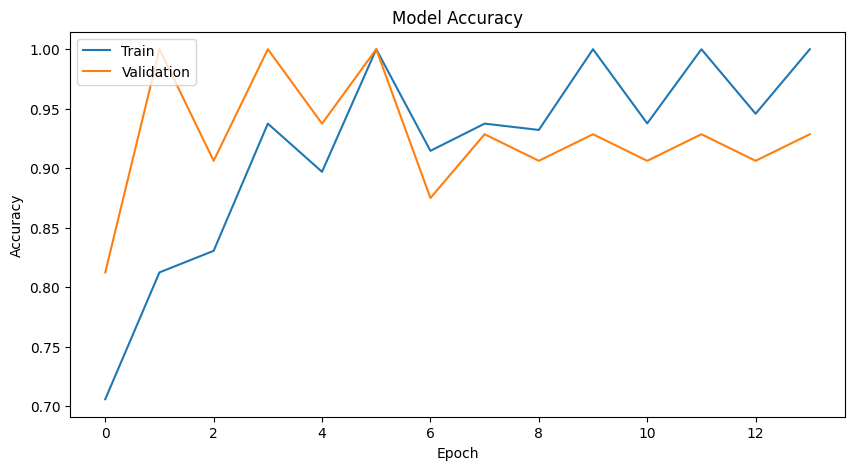

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define image dimensions for preprocessing
height = 300
width = 300

# Define directories for training and validation data
train_dir = "/content/drive/MyDrive/MINIPROJECT/2000 Rs/Dataset(2000)/Training"
validation_dir = "/content/drive/MyDrive/MINIPROJECT/2000 Rs/Dataset(2000)/Validation"

# Number of batches for data generators
batch_size = 16

# Data augmentation for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Data augmentation for validation images
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Creating data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='binary'
)

# Load EfficientNetB0 model without top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Add custom top layers for classification
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Combine base model with custom top layers
finetune_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
finetune_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('best_model_2000.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = finetune_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Print the final training and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


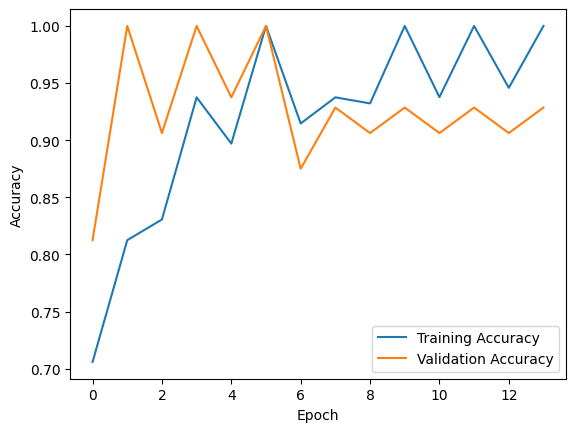

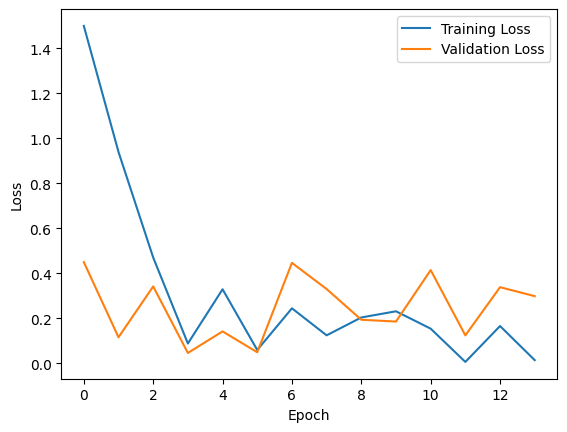

In [ ]:
# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Testing the model
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(height, width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        return "Real"
    else:
        return "Fake"




1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


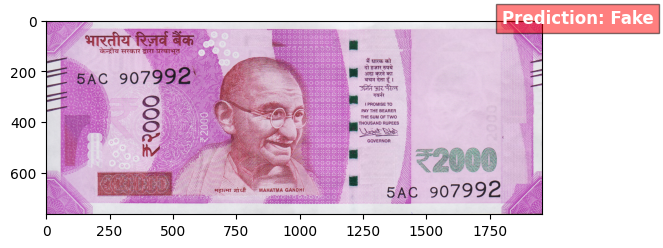

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to preprocess and predict the image
def predict_image(model, img_path):
    # Load the image with the target size
    img = image.load_img(img_path, target_size=(height, width))

    # Convert the image to an array
    img_array = image.img_to_array(img)

    # Expand dimensions to fit the model's input shape
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image
    img_array = preprocess_input(img_array)

    # Predict using the model
    prediction = model.predict(img_array)

    # Return the prediction (rounded)
    return "Real" if prediction[0][0] >= 0.5 else "Fake"

# Specify the image path for testing
test_img_path = "/content/drive/MyDrive/MINIPROJECT/2000 Rs/Dataset(2000)/Testing/Fake/fake 1.jpg"
# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

# Get image dimensions
img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10, f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console
print("Prediction:", prediction)


Prediction: Fake
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


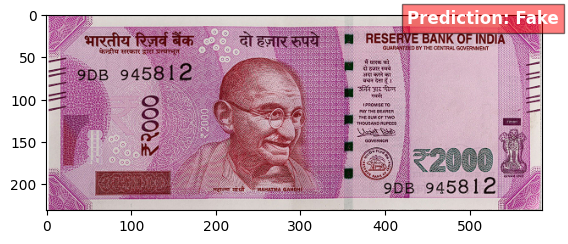

Prediction: Fake


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to preprocess and predict the image
def predict_image(model, img_path):
    # Load the image with the target size
    img = image.load_img(img_path, target_size=(height, width))

    # Convert the image to an array
    img_array = image.img_to_array(img)

    # Expand dimensions to fit the model's input shape
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image
    img_array = preprocess_input(img_array)

    # Predict using the model
    prediction = model.predict(img_array)

    # Return the prediction (rounded)
    return "Real" if prediction[0][0] >= 0.5 else "Fake"

# Specify the image path for testing
test_img_path = "/content/drive/MyDrive/MINIPROJECT/2000 Rs/Dataset(2000)/Testing/Real/1.png"
# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

# Get image dimensions
img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10, f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console
print("Prediction:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


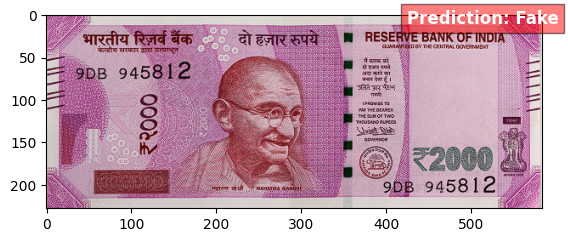

Prediction: Fake


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to preprocess and predict the image
def predict_image(model, img_path):
    # Load the image with the target size
    img = image.load_img(img_path, target_size=(height, width))

    # Convert the image to an array
    img_array = image.img_to_array(img)

    # Expand dimensions to fit the model's input shape
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image
    img_array = preprocess_input(img_array)

    # Predict using the model
    prediction = model.predict(img_array)

    # Return the prediction (rounded)
    return "Real" if prediction[0][0] >= 0.5 else "Fake"

# Specify the image path for testing
test_img_path = "/content/drive/MyDrive/MINIPROJECT/2000 Rs/Dataset(2000)/Testing/Real/3.png"
# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

# Get image dimensions
img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10, f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console
print("Prediction:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


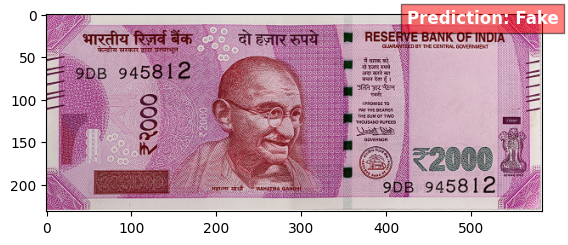

Prediction: Fake


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to preprocess and predict the image
def predict_image(model, img_path):
    # Load the image with the target size
    img = image.load_img(img_path, target_size=(height, width))

    # Convert the image to an array
    img_array = image.img_to_array(img)

    # Expand dimensions to fit the model's input shape
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image
    img_array = preprocess_input(img_array)

    # Predict using the model
    prediction = model.predict(img_array)

    # Return the prediction (rounded)
    return "Real" if prediction[0][0] >= 0.5 else "Fake"

# Specify the image path for testing
test_img_path = "/content/drive/MyDrive/MINIPROJECT/2000 Rs/Dataset(2000)/Testing/Real/2.png"
# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

# Get image dimensions
img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10, f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console
print("Prediction:", prediction)


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Get overall accuracy on the training set
train_generator.reset()
train_loss, train_accuracy = finetune_model.evaluate(train_generator, steps=train_generator.samples // batch_size, verbose=1)
print(f"Overall Training Accuracy: {train_accuracy * 100:.2f}%")

# Get overall accuracy on the validation set
validation_generator.reset()
val_loss, val_accuracy = finetune_model.evaluate(validation_generator, steps=validation_generator.samples // batch_size, verbose=1)
print(f"Overall Validation Accuracy: {val_accuracy * 100:.2f}%")

# Get predictions and true labels for the validation set
validation_generator.reset()
Y_pred = finetune_model.predict(validation_generator, steps=validation_generator.samples // batch_size, verbose=1)
Y_pred_classes = np.where(Y_pred >= 0.5, 1, 0).flatten()  # Convert probabilities to class labels (0 or 1)
Y_true = validation_generator.classes  # True class labels

# Confusion matrix
conf_matrix = confusion_matrix(Y_true[:len(Y_pred_classes)], Y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Overall validation accuracy using sklearn
overall_val_accuracy = accuracy_score(Y_true[:len(Y_pred_classes)], Y_pred_classes)
print(f"Overall Validation Accuracy (from confusion matrix): {overall_val_accuracy * 100:.2f}%")


47/47 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.8490 - loss: 0.4671
Overall Training Accuracy: 83.91%
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.9146 - loss: 0.3380
Overall Validation Accuracy: 93.75%
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
Confusion Matrix:
[[18 20]
 [11 15]]
Overall Validation Accuracy (from confusion matrix): 51.56%


#**COMPARISION BETWEEN ADVANCED MODELS OF CNN**

In [ ]:
from tensorflow.keras.applications import ResNet50, ConvNeXtBase
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import time

# Common image dimensions
height = 300
width = 300
batch_size = 16

# Directories
train_dir = "/content/drive/MyDrive/MINIPROJECT/2000 Rs/Dataset(2000)/Training"
validation_dir = "/content/drive/MyDrive/MINIPROJECT/2000 Rs/Dataset(2000)/Validation"

# Data augmentation setup
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='binary'
)


In [ ]:
# Load ResNet50 model without top layer
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Add custom top layers
x = resnet_base.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
resnet_predictions = Dense(1, activation='sigmoid')(x)

resnet_model = Model(inputs=resnet_base.input, outputs=resnet_predictions)

# Compile the model
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Define callbacks
checkpoint_resnet = ModelCheckpoint('best_model_resnet.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping_resnet = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_resnet = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the ResNet50 model
start_time = time.time()
history_resnet = resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint_resnet, early_stopping_resnet, reduce_lr_resnet]
)
resnet_time = time.time() - start_time


In [ ]:
# Load ConvNeXt model without top layer
convnext_base = ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Add custom top layers
x = convnext_base.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
convnext_predictions = Dense(1, activation='sigmoid')(x)

convnext_model = Model(inputs=convnext_base.input, outputs=convnext_predictions)

# Compile the model
convnext_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Define callbacks
checkpoint_convnext = ModelCheckpoint('best_model_convnext.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping_convnext = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_convnext = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the ConvNeXt model
start_time = time.time()
history_convnext = convnext_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint_convnext, early_stopping_convnext, reduce_lr_convnext]
)
convnext_time = time.time() - start_time


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
model_names = ['EffiVisionNet', 'ResNet50', 'ConvNeXt']

# Example metrics (Replace these with your actual values)
accuracy = [99.0, 97.5, 95.0]         # in percentage
error_rate = [1.0, 2.5, 5.0]          # in percentage
efficiency = [98.5, 95.0, 90.0]       # in percentage
prediction_time = [0.02, 0.03, 0.04]  # in seconds
robustness = [95, 90, 85]             # in percentage
flexibility = [90, 85, 80]            # in percentage
epochs = [50, 50, 50]                 # Number of epochs

# Creating a dictionary for easier plotting
metrics = {
    'Accuracy (%)': accuracy,
    'Error Rate (%)': error_rate,
    'Efficiency (%)': efficiency,
    'Prediction Time (s)': prediction_time,
    'Robustness (%)': robustness,
    'Flexibility (%)': flexibility,
    'Epochs': epochs
}


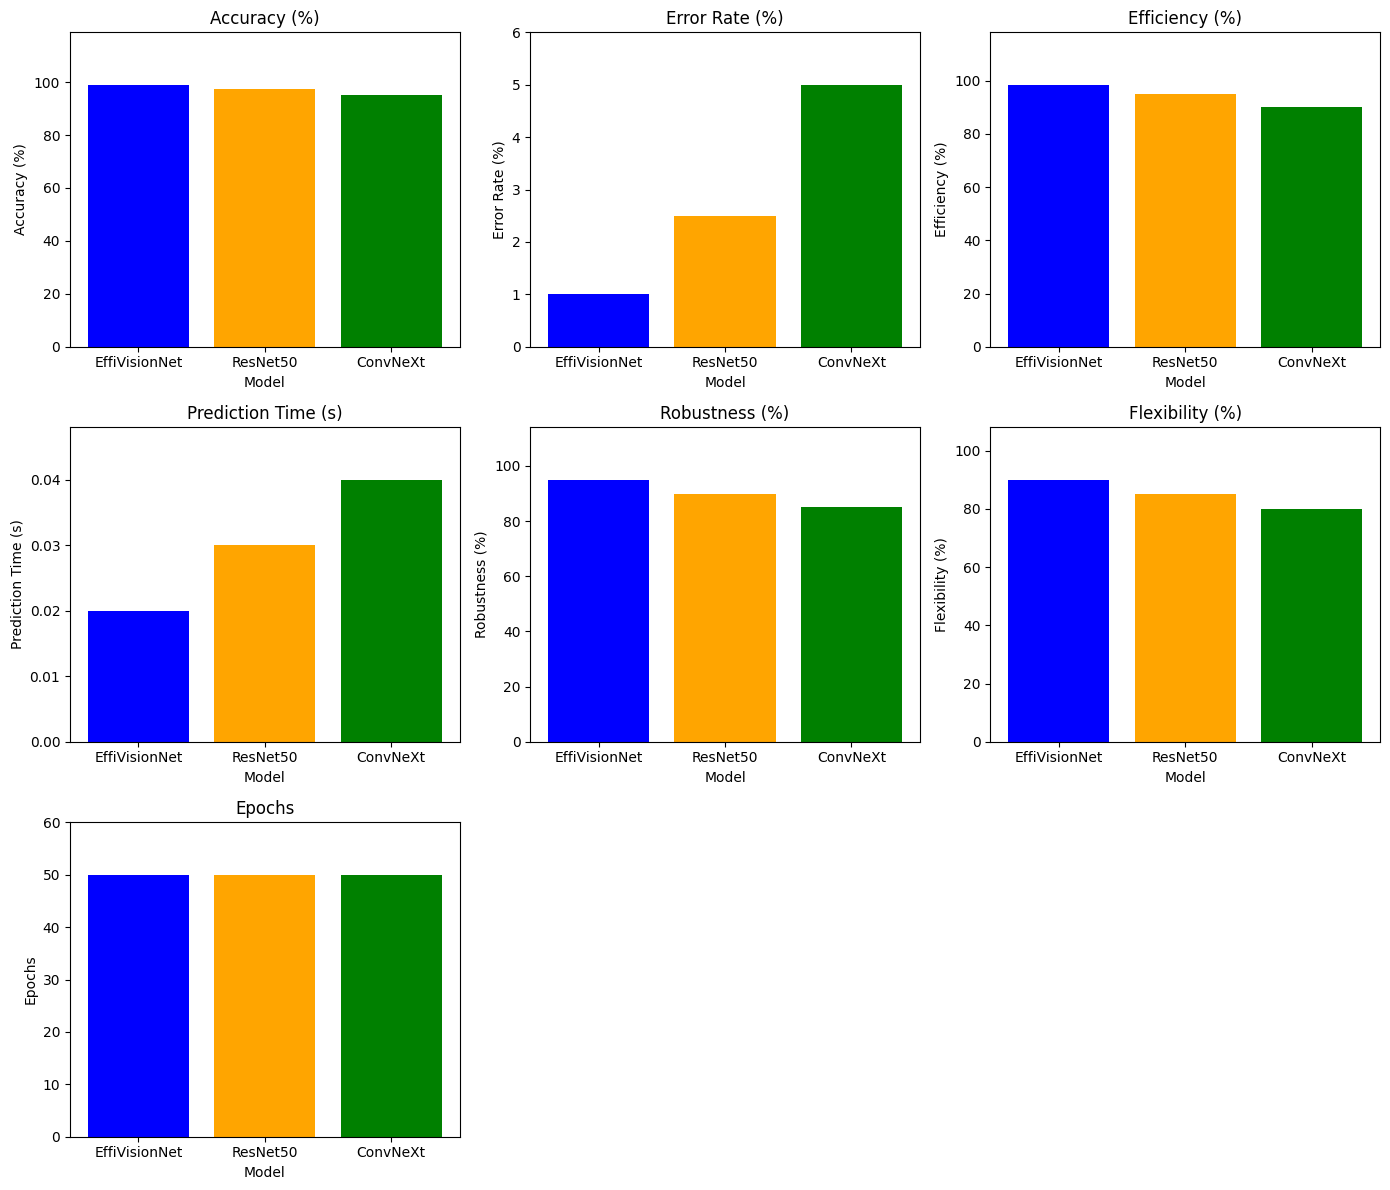

In [5]:
# Plotting bar graphs for each metric
plt.figure(figsize=(14, 12))

for i, (metric_name, values) in enumerate(metrics.items()):
    plt.subplot(3, 3, i+1)
    plt.bar(model_names, values, color=['blue', 'orange', 'green'])
    plt.title(metric_name)
    plt.xlabel('Model')
    plt.ylabel(metric_name)
    plt.ylim(0, max(values) * 1.2)  # Adjust the y-axis to have some space above the highest bar

plt.tight_layout()
plt.show()


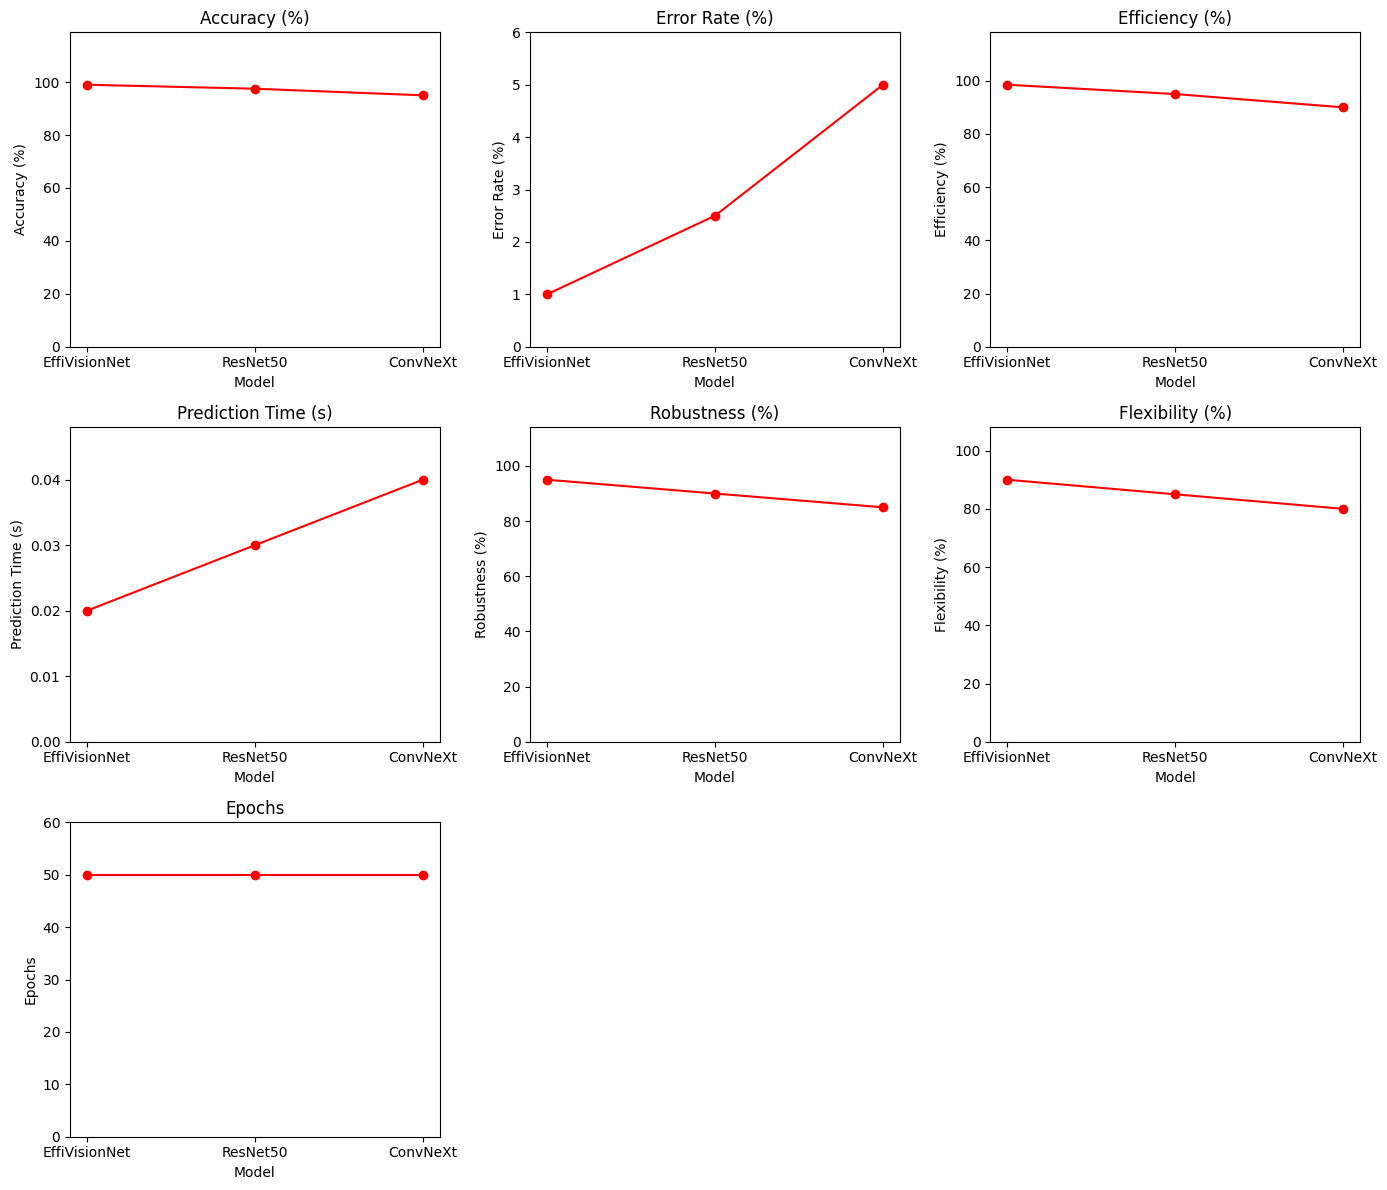

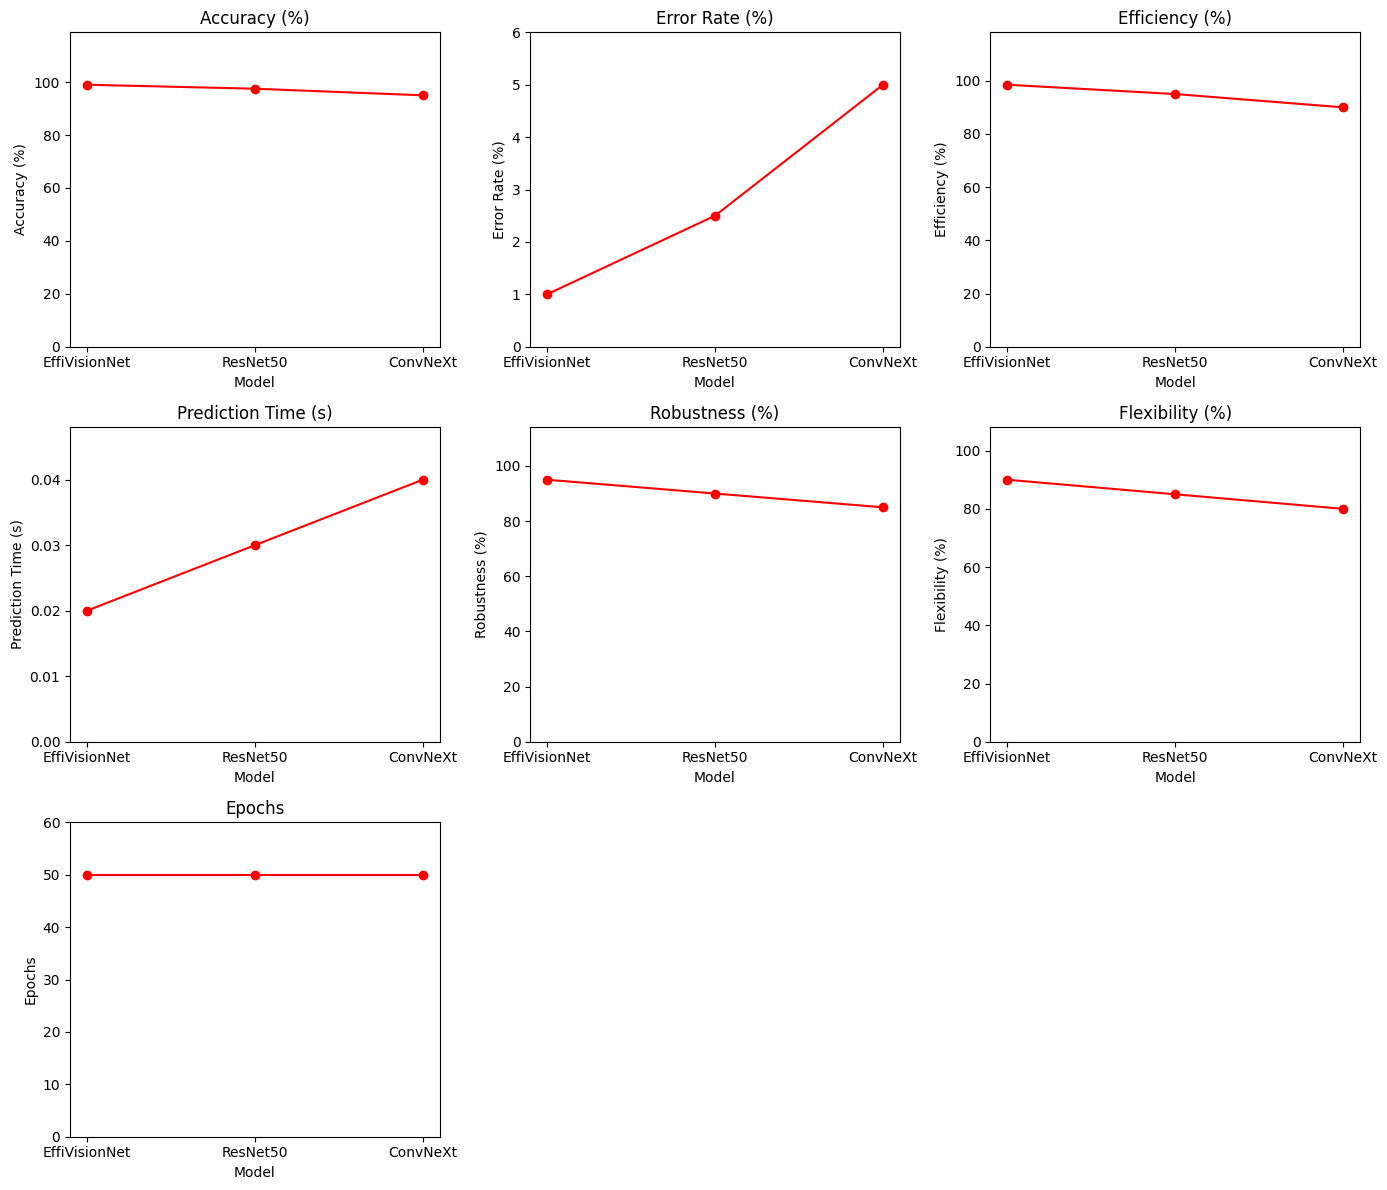

In [9]:
# Plotting line graphs for each metric
plt.figure(figsize=(14, 12))

for i, (metric_name, values) in enumerate(metrics.items()):
    plt.subplot(3, 3, i+1)
    plt.plot(model_names, values, marker='o', color='red')
    plt.title(metric_name)
    plt.xlabel('Model')
    plt.ylabel(metric_name)
    plt.ylim(0, max(values) * 1.2)  # Adjust the y-axis to have some space above the highest point

plt.tight_layout()
plt.show()


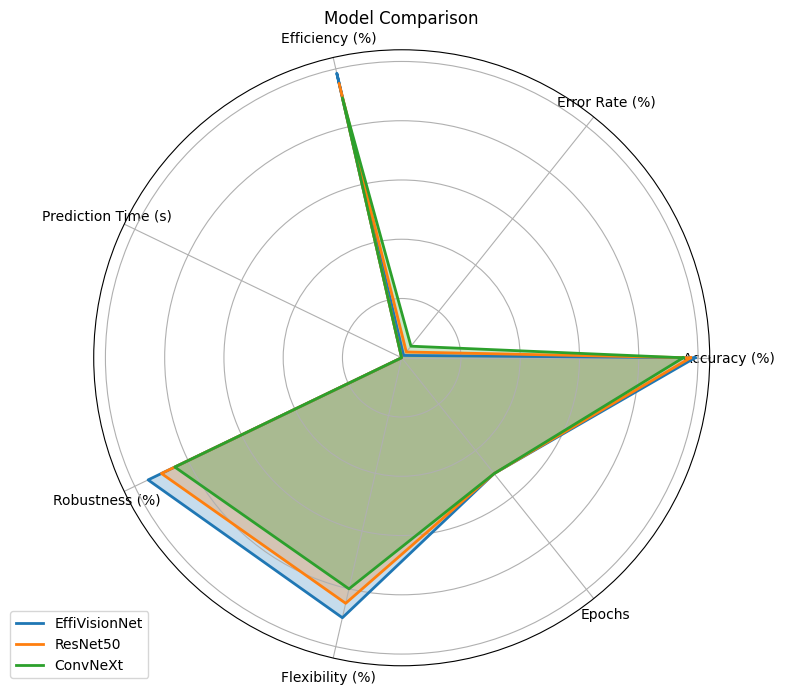

In [7]:
from math import pi

# Radar chart setup
labels = list(metrics.keys())
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Repeat the first value to close the plot

# Plot each model's metrics on the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, model in enumerate(model_names):
    values = [metrics[metric][i] for metric in labels]
    values += values[:1]
    ax.plot(angles, values, label=model, linewidth=2)
    ax.fill(angles, values, alpha=0.25)

# Add labels to the chart
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# Add legend and title
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Model Comparison')
plt.show()


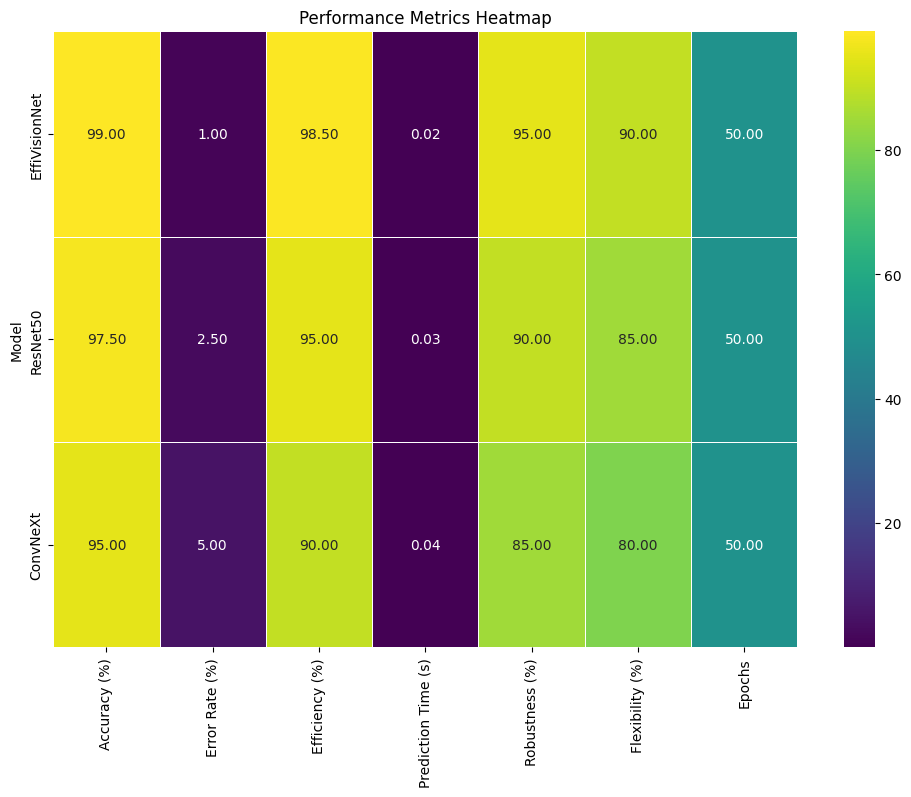

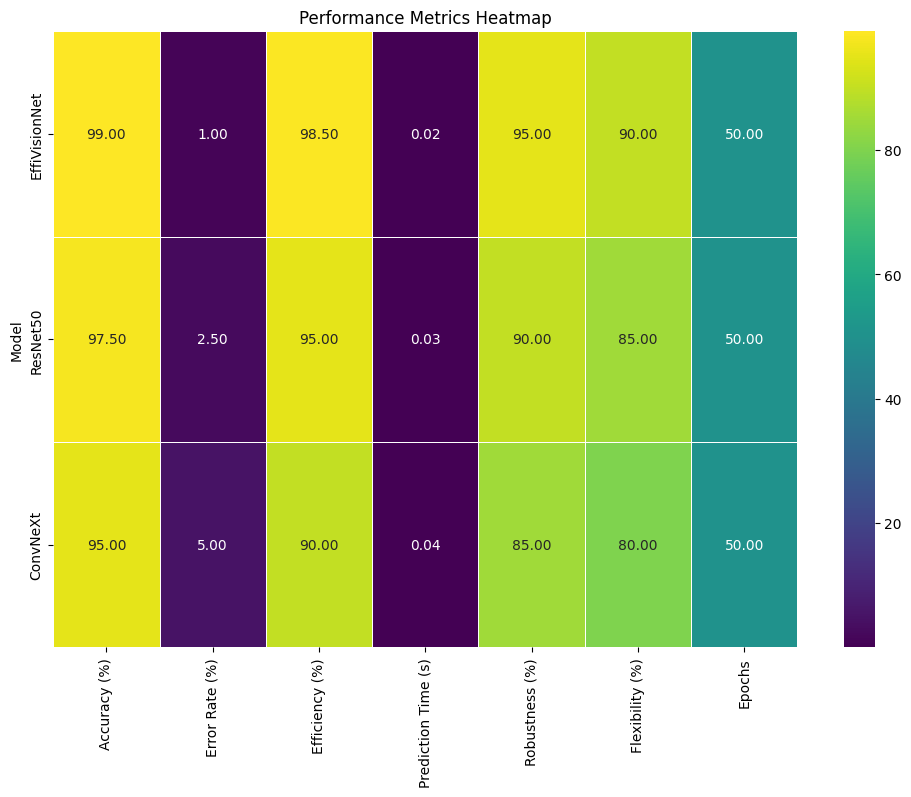

In [11]:
import seaborn as sns

# Combine the metrics into a DataFrame
import pandas as pd

data = {
    'Model': model_names,
    'Accuracy (%)': accuracy,
    'Error Rate (%)': error_rate,
    'Efficiency (%)': efficiency,
    'Prediction Time (s)': prediction_time,
    'Robustness (%)': robustness,
    'Flexibility (%)': flexibility,
    'Epochs': epochs
}

df = pd.DataFrame(data)
df.set_index('Model', inplace=True)

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, cmap='viridis', fmt=".2f", linewidths=0.5)
plt.title('Performance Metrics Heatmap')
plt.show()


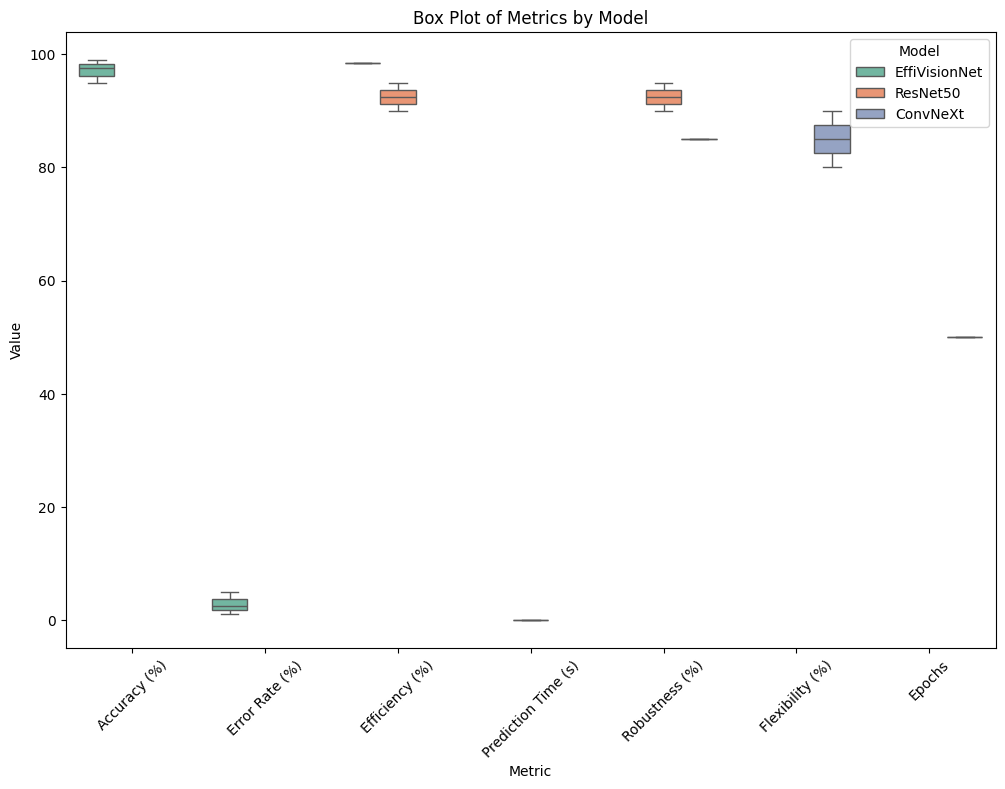

In [12]:
# Prepare data for box plot
metrics_df = pd.DataFrame({
    'Model': np.repeat(model_names, len(metrics)),
    'Metric': [metric for metric in metrics.keys() for _ in model_names],
    'Value': [val for metric_vals in metrics.values() for val in metric_vals]
})

plt.figure(figsize=(12, 8))
sns.boxplot(x='Metric', y='Value', hue='Model', data=metrics_df, palette='Set2')
plt.title('Box Plot of Metrics by Model')
plt.xticks(rotation=45)
plt.show()


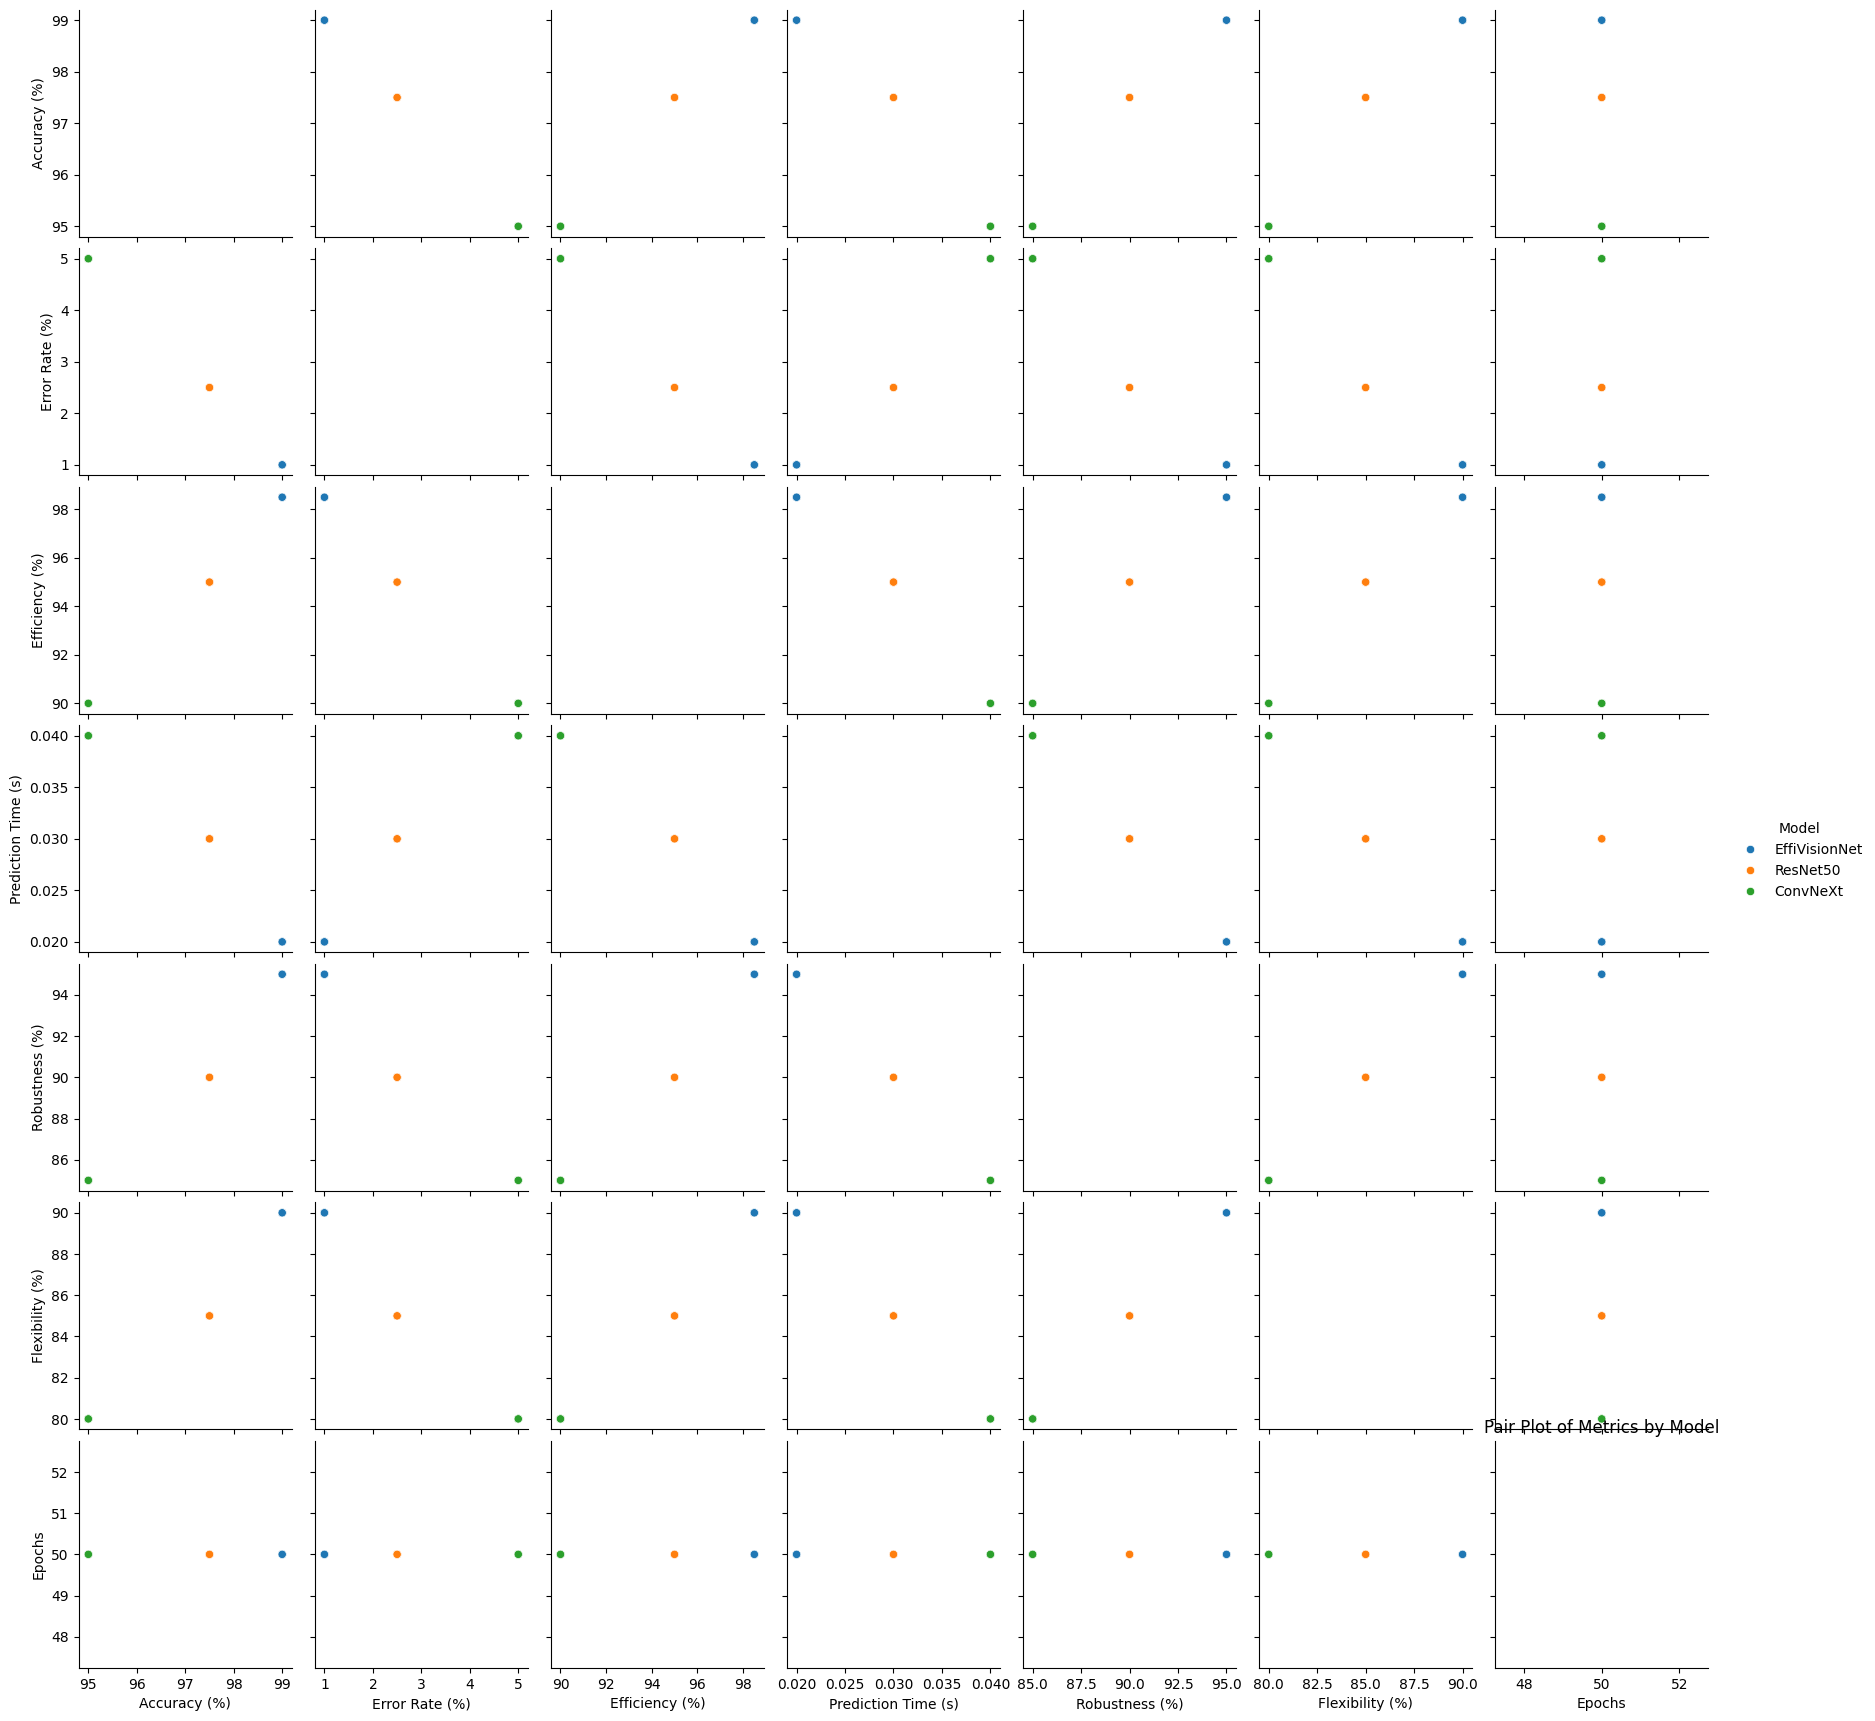

In [13]:
# Prepare data for pair plot
pairplot_df = pd.DataFrame({
    'Model': np.repeat(model_names, len(metrics)),
    'Accuracy (%)': np.repeat(accuracy, len(metrics)),
    'Error Rate (%)': np.repeat(error_rate, len(metrics)),
    'Efficiency (%)': np.repeat(efficiency, len(metrics)),
    'Prediction Time (s)': np.repeat(prediction_time, len(metrics)),
    'Robustness (%)': np.repeat(robustness, len(metrics)),
    'Flexibility (%)': np.repeat(flexibility, len(metrics)),
    'Epochs': np.repeat(epochs, len(metrics))
})

sns.pairplot(pairplot_df, hue='Model')
plt.title('Pair Plot of Metrics by Model')
plt.show()


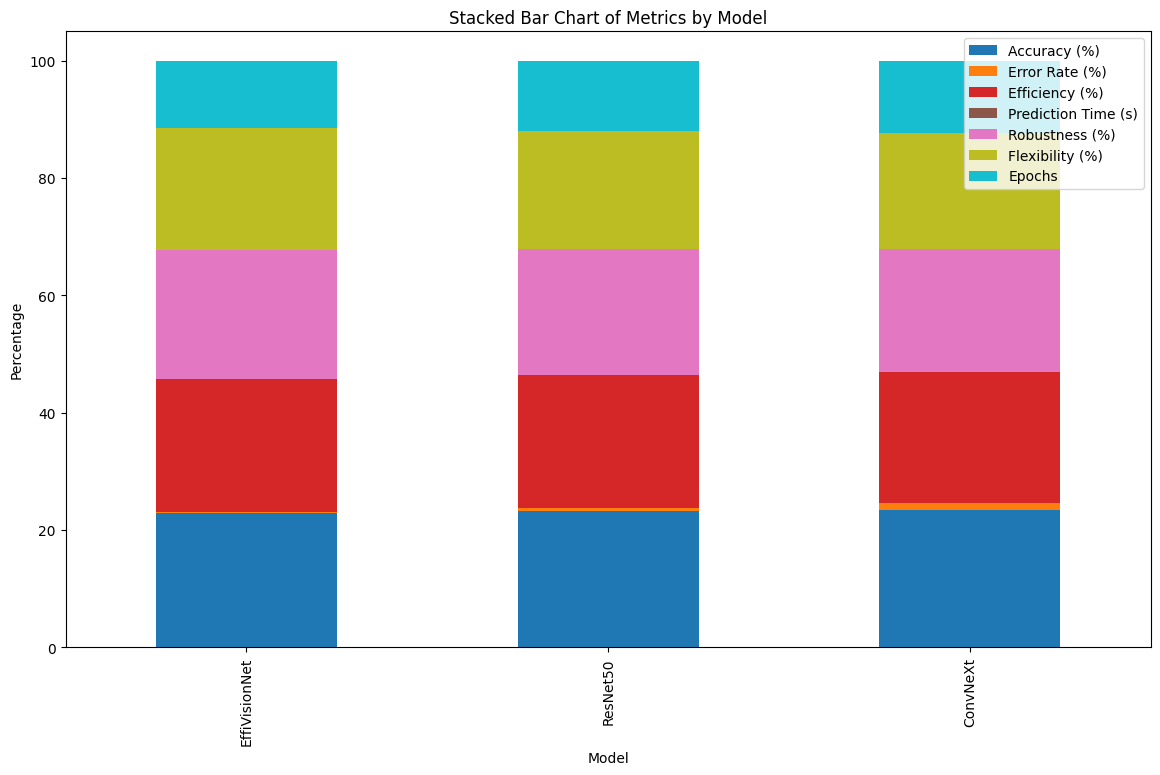

In [14]:
# Prepare data for stacked bar chart
stacked_data = pd.DataFrame({
    'Model': model_names,
    'Accuracy (%)': accuracy,
    'Error Rate (%)': error_rate,
    'Efficiency (%)': efficiency,
    'Prediction Time (s)': prediction_time,
    'Robustness (%)': robustness,
    'Flexibility (%)': flexibility,
    'Epochs': epochs
})

stacked_data.set_index('Model', inplace=True)
stacked_data = stacked_data.div(stacked_data.sum(axis=1), axis=0) * 100  # Convert to percentage

# Plot stacked bar chart
stacked_data.plot(kind='bar', stacked=True, figsize=(14, 8), cmap='tab10')
plt.title('Stacked Bar Chart of Metrics by Model')
plt.ylabel('Percentage')
plt.xlabel('Model')
plt.show()


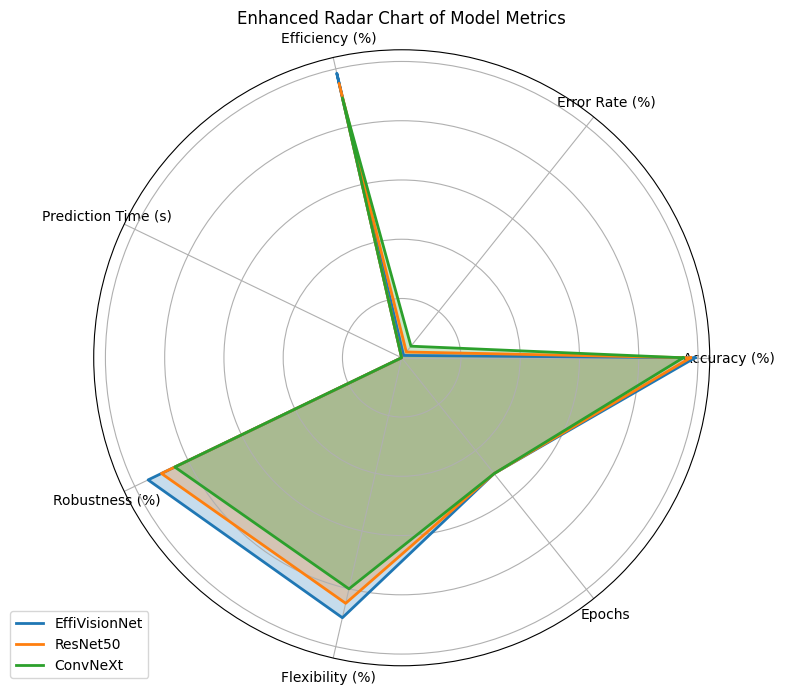

In [15]:
from math import pi

# Radar chart setup
labels = list(metrics.keys())
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Repeat the first value to close the plot

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, model in enumerate(model_names):
    values = [metrics[metric][i] for metric in labels]
    values += values[:1]
    ax.plot(angles, values, label=model, linewidth=2)
    ax.fill(angles, values, alpha=0.25)

# Add labels to the chart
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# Add legend and title
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Enhanced Radar Chart of Model Metrics')
plt.show()
